# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [78]:
# import libraries
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler, Normalizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Spark_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Validate below items and cleanse (if required)
1. Check for Nulls and Blanks in fields sessoinId and userId.
2. Check for the format of the field "ts" and modify if needed.

In [6]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [7]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [8]:
df.select('ts').head(5)

[Row(ts=1538352117000),
 Row(ts=1538352180000),
 Row(ts=1538352394000),
 Row(ts=1538352416000),
 Row(ts=1538352676000)]

In [9]:
df.filter(isnull(df['sessionId'])).count()

0

In [10]:
df.filter(df['sessionId']=='').count()

0

There are no nulls / blanks in sessionId

In [11]:
df.filter(isnull(df['userId'])).count()

0

In [12]:
df.filter(df['userId']=='').count()

8346

There 8,346 records with blank values in UserId. These records are to be filtered out.

In [13]:
# Filter out records where userid is blank
df_clean = df.filter(df['userId']!='')

In [14]:
# Create a function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [15]:
#Apply the fix in the dataframe
df_clean = df_clean.withColumn("time", get_time(df_clean.ts))

In [16]:
# check the cleaned data set
df_clean.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|               time|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

##### Preliminary Data Analysis

In [17]:
#Create a view to perform SQL operations
df_clean.createOrReplaceTempView("clean_dataset")

In [18]:
# Look at user split based on Gender

gender_count = spark.sql('''
        select gender,count(distinct userId) as Count
        from clean_dataset
        group by gender
''')
gender_count.show()

+------+-----+
|gender|Count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



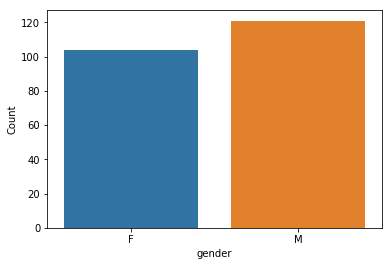

In [19]:
sns.barplot(x='gender',y='Count',data=gender_count.toPandas());

There are more male users in this data set

In [20]:
spark.sql('''
        Select Distinct(auth)
        from clean_dataset
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [21]:
# Find number of users logged in Vs Cancelled
user_log = spark.sql('''
        Select auth,count(Distinct userId) as Count
        from clean_dataset
        group by auth
        order by Count desc
''')
user_log.show()

+---------+-----+
|     auth|Count|
+---------+-----+
|Logged In|  225|
|Cancelled|   52|
+---------+-----+



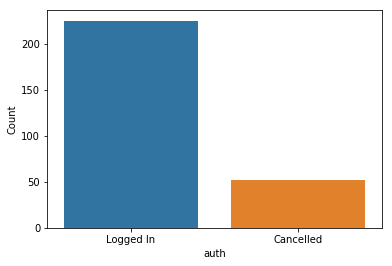

In [22]:
sns.barplot(x='auth',y='Count',data=user_log.toPandas());

There are 52 users who have cancelled their account. 

In [23]:
# Subcription Type
sub_type = spark.sql('''
        Select level,count(Distinct userId) as Count
        FROM clean_dataset
        GROUP BY level
        ORDER BY Count Desc
''')
sub_type.show()

+-----+-----+
|level|Count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



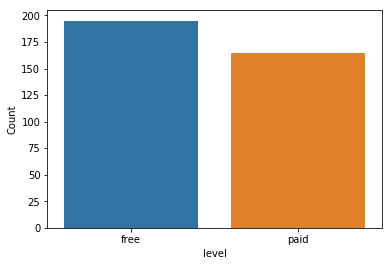

In [24]:
sns.barplot(x='level',y='Count',data=sub_type.toPandas());

There are 165 paid and 195 free accounts as per the data set.

In [25]:
# Location wise data
loc_count = spark.sql('''
        Select location,count(Distinct userId) as Count
        from clean_dataset
        group by location
        order by Count Desc
''')
loc_count.show()

+--------------------+-----+
|            location|Count|
+--------------------+-----+
|Los Angeles-Long ...|   16|
|New York-Newark-J...|   15|
|Dallas-Fort Worth...|    7|
|Phoenix-Mesa-Scot...|    7|
|    St. Louis, MO-IL|    6|
|Chicago-Napervill...|    6|
|Charlotte-Concord...|    6|
|Philadelphia-Camd...|    5|
|Miami-Fort Lauder...|    5|
|Boston-Cambridge-...|    5|
|Atlanta-Sandy Spr...|    4|
|Washington-Arling...|    4|
|Houston-The Woodl...|    4|
|San Diego-Carlsba...|    3|
|Las Vegas-Henders...|    3|
|New Haven-Milford...|    3|
|Providence-Warwic...|    2|
|San Antonio-New B...|    2|
|Indianapolis-Carm...|    2|
|         Jackson, MS|    2|
+--------------------+-----+
only showing top 20 rows



In [26]:
# Split City & State in location
loc_df = loc_count.toPandas()
loc_split = loc_df.join(loc_df['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)

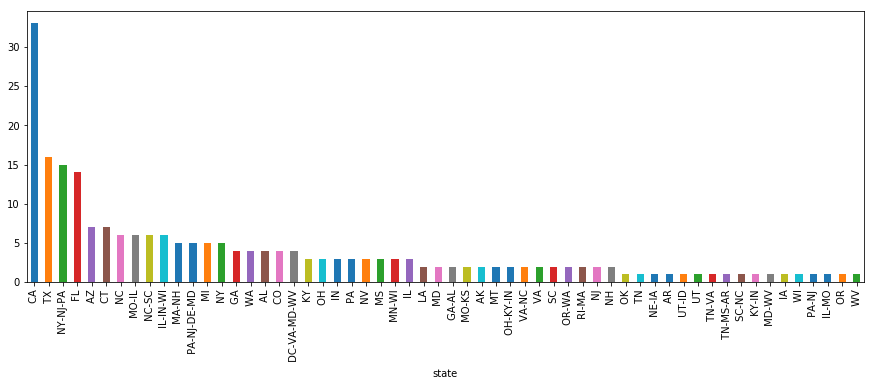

In [27]:
loc_split.groupby('state')['Count'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(15,5));

California is the clear leader in terms of number of users compared to other states in the dataset

In [28]:
# Split users by Day of the Week
week_dict = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}

filter_data = spark.sql('''
        SELECT time,userId
        FROM clean_dataset
''').toPandas()

In [29]:
filter_data['time'] = pd.to_datetime(filter_data['time'])
filter_data['weekday'] = filter_data['time'].dt.weekday.map(week_dict)

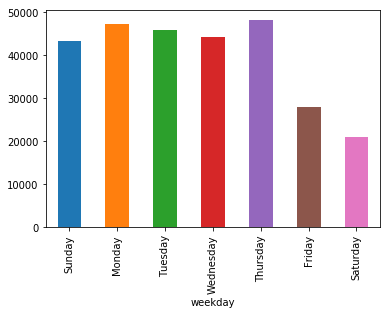

In [30]:
filter_data.groupby('weekday')['userId'].count().loc[list(week_dict.values())].plot(kind='bar');

Users use Sparkify more often during weekdays compared to weekends, specifically there is a big dip in the numbers on friday and Saturday.

In [31]:
# User Agent
useragent_count = spark.sql('''
        Select userAgent,count(Distinct userId) AS Count
        from clean_dataset
        group by userAgent
        order by Count desc
''').toPandas()

In [32]:
# Define a function to assign browser names
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'Explorer'
    else:
        return np.NaN

In [33]:
useragent_count['browser'] = useragent_count['userAgent'].apply(get_browser)

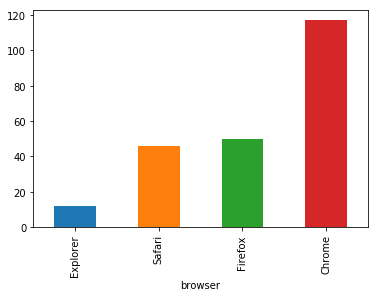

In [34]:
useragent_count.groupby('browser')['Count'].sum().sort_values().plot(kind='bar');

Majority of users use Chrome compared to other browsers.

In [35]:
# Define a function to assign browser names
def get_platform(x):
    if 'Windows' in x:
        return 'Windows'
    if 'compatible' in x:
        return 'Windows'
    elif 'Mac' in x:
        return 'Mac'
    elif 'X11' in x:
        return 'Linux'
    elif 'iPad' in x:
        return 'Mobile Devices'
    elif 'iPhone' in x:
        return 'Mobile Devices'
    else:
        return np.NaN

In [36]:
useragent_count['platform'] = useragent_count['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].apply(get_platform)

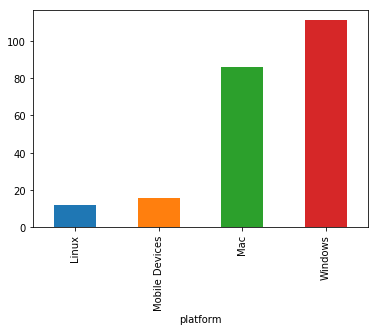

In [37]:
useragent_count.groupby('platform')['Count'].sum().sort_values().plot(kind='bar');

Surprisingly there are large number of users using Windows / Mac compared to Mobile devices.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [38]:
#Identify a flag event

df_clean.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [39]:
#Define Churn

flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df_clean_cancel = df_clean.withColumn('Churn_Event',flag_event('page'))

In [40]:
user = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_clean_cancel = df_clean_cancel.withColumn('Churn',fmax('Churn_Event').over(user))

In [41]:
df_clean_cancel.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10-08 12:58:54', Churn_Event=0, Churn=0)]

In [42]:
# identify counts of churn vs not churn
df_clean_cancel.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=173)]

The rate of churn is less than 25% of the total which means this is an unblanced dataset. 

The next step is to identify churns across different variables like Gender, Auth, location etc...

In [43]:
# Churn based on Gender
df_clean_cancel.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



In [44]:
proportions_ztest([32,20],[121,104],alternative='two-sided')

(1.2800974409737422, 0.20051086855629463)

Looking just at the Churn rate, Males seem to be have a slightly better rate than females (0.264 vs 0.191) but 
a p-value of 0.20 indicates Gender doesnt play a role on Churn or Not Churn.

In [45]:
# Churn based on Auth
df_clean_cancel.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



Auth has no effect on Churn

In [46]:
# Churn based on Location
split_city_state = split(df_clean_cancel['location'], ',')
df_clean_cancel = df_clean_cancel.withColumn('state',split_city_state.getItem(1))

state_data = df_clean_cancel.dropDuplicates(["userId"]).groupby(["state","Churn"]).count().sort("state").toPandas()

In [47]:
# Normalize dataset
def normalize_dataset(input_data):
    series = input_data.set_index(list(input_data.columns[:2]))
    temp = series.unstack('Churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]:'result'})
    return df

In [48]:
state_data = normalize_dataset(state_data)

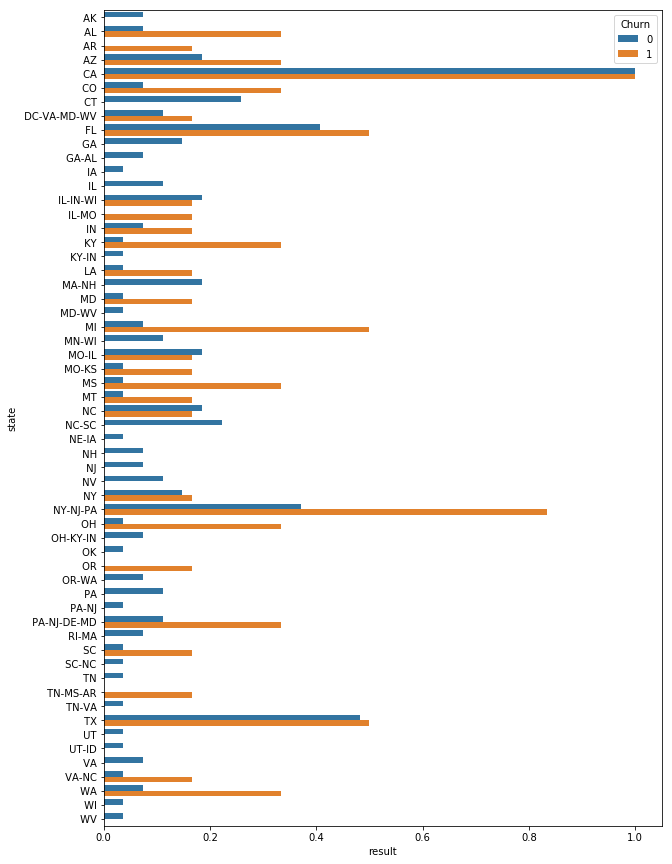

In [49]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="result",y="state", hue="Churn", data=state_data,ax=ax);

In [50]:
# Churn based on Time
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%a'))
get_weekdaynum = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [51]:
df_clean_cancel = df_clean_cancel.withColumn('hour', get_hour(df_clean_cancel.ts))
df_clean_cancel = df_clean_cancel.withColumn('day', get_day(df_clean_cancel.ts))
df_clean_cancel = df_clean_cancel.withColumn('weekday', get_weekday(df_clean_cancel.ts))
df_clean_cancel =  df_clean_cancel.withColumn('weekdaynum', get_weekdaynum(df_clean_cancel.ts))

In [52]:
hour = df_clean_cancel.select(["Churn", "hour"]).groupby(["Churn", "hour"]).count().sort("hour").toPandas()
day = df_clean_cancel.select(["Churn", "day"]).groupby(["Churn", "day"]).count().sort("day").toPandas()
weekday = df_clean_cancel.select(["Churn", "weekday"]).groupby(["Churn", "weekday"]).count().sort("weekday").toPandas()

In [53]:
hour = normalize_dataset(hour)

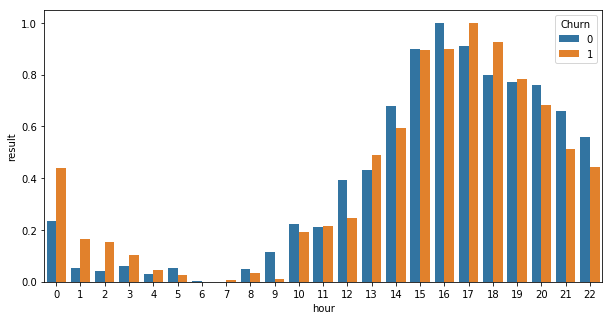

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="hour",y="result", hue="Churn", data=hour,ax=ax,order=list(map(lambda x: str(x),range(23))));

In [55]:
day = normalize_dataset(day)

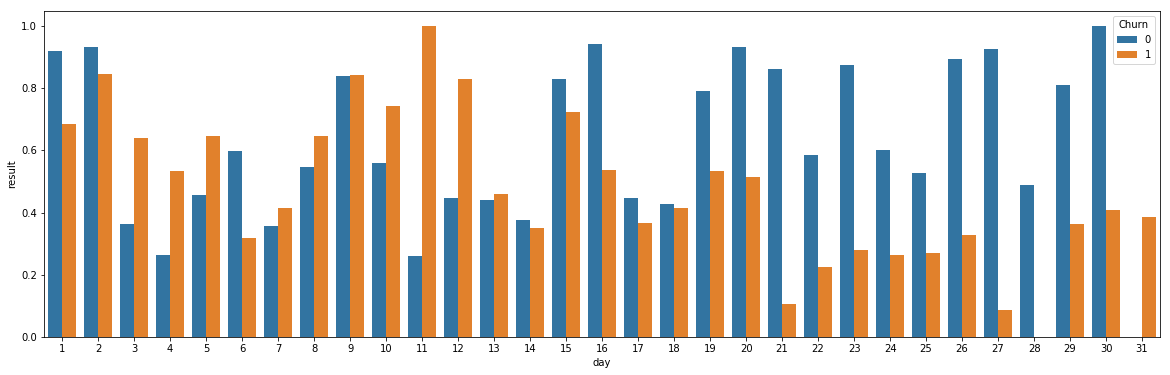

In [56]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot( x="day",y="result", hue="Churn", data=day,ax=ax,order=list(map(lambda x: str(x),range(1,32))));

In [57]:
weekday = normalize_dataset(weekday)

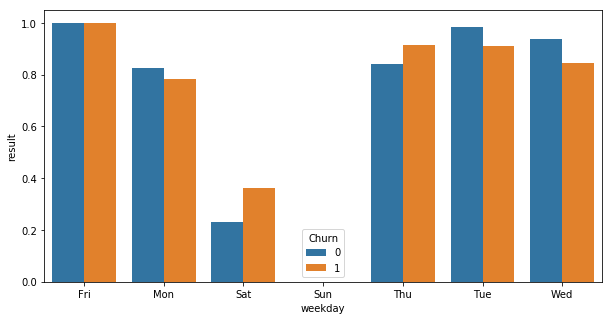

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="weekday",y="result", hue="Churn", data=weekday,ax=ax);

In [59]:
# Churn based on Browser Type
browser = udf(lambda x : get_browser(x))

In [60]:
df_clean_cancel = df_clean_cancel.withColumn('browser',browser(df_clean_cancel.userAgent))
df_browser = df_clean_cancel.select(["browser","Churn"]).groupby([ "browser","Churn"]).count().sort("browser").toPandas()
df_browser = normalize_dataset(df_browser)

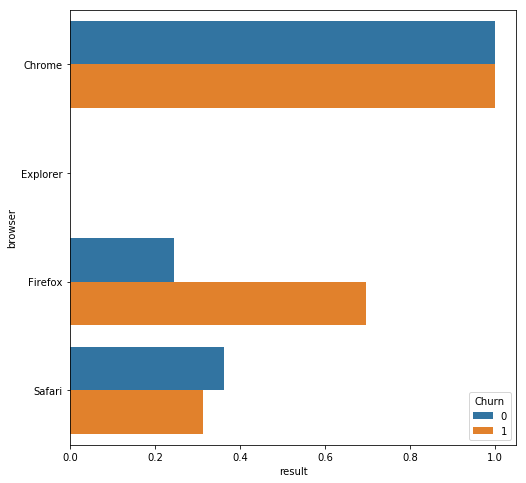

In [61]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="browser", hue="Churn", data=df_browser,ax=ax);

In [62]:
#Churn based on Platform used
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

platform = udf(lambda x: platform_dict[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]])
df_clean_cancel = df_clean_cancel.withColumn('platform',platform(df_clean_cancel.userAgent))

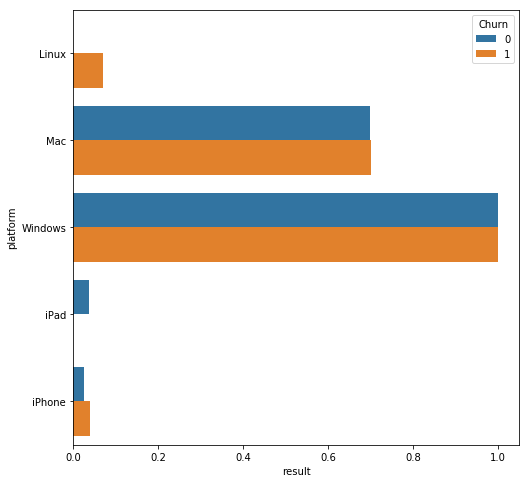

In [63]:
df_platform = df_clean_cancel.select(["platform","Churn"]).groupby([ "platform","Churn"]).count().sort("platform").toPandas()
df_platform = normalize_dataset(df_platform)


fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="platform", hue="Churn", data=df_platform,ax=ax);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [64]:
df_clean_cancel.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churn_Event: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- weekdaynum: string (nullable = true)

Based on the EDA, we can work with the below Categorical and numerical features.

    . Categorical Features
        1. Gender
        2. Level
        3. Browser
        4. Platform
    . Numerical Features
        1. mean,max,min and std dev of length of users
        2. number of these items in a page (NextSong, ThumbsUp, ThumbsDown, AddtoPlaylist, AddFriend, RollAdvert)
        2. number of unique songs and total songs of users
        3. number of unique artists of users
        4. percentage of operations towards starting of the month (first 10 days)
        5. percentage of operations in a working day

In [65]:
# Encoding Categorical features to a number
def label_encoding(col_name):
    temp = df_clean_cancel.select([col_name]).dropDuplicates().toPandas()
    label_dict = {val:str(idx) for idx,val in enumerate(temp[col_name].tolist())}
    result = df_clean_cancel.dropDuplicates(['userId']).select(['userId',col_name]).replace(label_dict,subset=col_name)
    return result

In [66]:
# Combine the categorical features
def get_cat_features():
    feature_gender = label_encoding('gender')
    feature_level = label_encoding('level')
    feature_browser = label_encoding('browser')
    feature_platform = label_encoding('platform')
    
    result = feature_gender.join(feature_level,on='userId',how='inner').\
                            join(feature_browser,on='userId',how='inner').\
                            join(feature_platform,on='userId',how='inner')
    return result

In [67]:
cat_feature = get_cat_features()
cat_feature.show(2)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
+------+------+-----+-------+--------+
only showing top 2 rows



In [68]:
# Combine Numerical Features
def get_num_features():
    #length
    feature_length = df_clean_cancel.select(["userId", "length"]).groupby(["userId"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length'))
    
    #page
    page_count = df_clean_cancel.select(["userId","page"]).groupby(["userId","page"]).count()
    # create the pivot table
    temp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    # filter columns
    temp1 = temp1.select(['userId','NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'])
    # column names used to sum up for total
    cols = temp1.columns[1:]
    # calculate the total 
    feature_page = temp1.withColumn('total', sum([col(c) for c in cols]))  
    
    #number of unique songs
    feature_nunique_song = df_clean_cancel.filter(df_clean_cancel.page=='NextSong').select(["userId","song"]).\
                                             dropDuplicates(["userId","song"]).groupby(["userId"]).count()
    
    feature_nunique_song = feature_nunique_song.selectExpr("userId as userId","count as nunique_song")
    
    #number of total songs
    feature_ntotal_song = df_clean_cancel.filter(df_clean_cancel.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count()
    
    feature_ntotal_song = feature_ntotal_song.selectExpr("userId as userId","count as ntotal_song")
    
    #number of unique artists
    feature_nunique_artist = df_clean_cancel.filter(df_clean_cancel.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
    
    feature_nunique_artist = feature_nunique_artist.selectExpr("userId as userId","count as nunique_artist")
    
    #percentage of operations
    day_count = df_clean_cancel.filter(df_clean_cancel.day<=10).select(['userId']).groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId","count as day_count")
    
    total_count = df_clean_cancel.select(['userId']).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId","count as total_count")
    
    dayofweek_count = df_clean_cancel.filter(df_clean_cancel.weekdaynum<5).select(['userId']).groupby(["userId"]).count()
    dayofweek_count = dayofweek_count.selectExpr("userId as userId","count as dayofweek_count")
    
    feature_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"]).\
                              select(col("userId"), (col("day.day_count") / col("total.total_count")).alias("month_percentage")))
    
    feature_percentage_week = (total_count.alias("total").join(dayofweek_count.alias("day"), ["userId"]).\
                          select(col("userId"), (col("day.dayofweek_count") / col("total.total_count")).alias("week_percentage")))
    
    #merge together
    result = feature_length.join(feature_page,on='userId',how='inner').\
                        join(feature_percentage_month,on='userId',how='inner').\
                        join(feature_nunique_song,on='userId',how='inner').\
                        join(feature_ntotal_song,on='userId',how='inner').\
                        join(feature_nunique_artist,on='userId',how='inner').\
                        join(feature_percentage_week,on='userId',how='inner')
    
    return result

In [69]:
label = df_clean_cancel.select(['userId','Churn']).dropDuplicates()

In [70]:
# Merge 
def get_data_for_train():
    cat_feature = get_cat_features()
    num_feature = get_num_features()
    label = df_clean_cancel.select(['userId','Churn']).dropDuplicates()
    result = cat_feature.join(num_feature,on='userId',how='inner').join(label,on='userId',how='inner')
    
    # Convert Data type
    for col_name in result.columns[1:5]:
        result = result.withColumn(col_name, result[col_name].cast(IntegerType()))
    
    for col_name in result.columns[5:-1]:
        result = result.withColumn(col_name, result[col_name].cast(FloatType()))
        
    #fill NaN
    result = result.na.fill(0)
    
  
    return result

In [71]:
final_data = get_data_for_train()

In [72]:
data_columns = final_data.columns
data_columns.remove('Churn')
data_columns.remove('userId')

In [73]:
cat_features = ['gender','level','browser','platform']
num_features = [col_name for col_name in data_columns if col_name not in cat_features]

In [74]:
df = final_data.toPandas()

In [75]:
df.shape

(209, 22)

In [76]:
# combine features using VecotrAssembler
assembler = VectorAssembler(inputCols=data_columns, outputCol="ChurnFeatures")
df_processed = assembler.transform(final_data)

In [79]:
# scale features using Normalizer
scaler = Normalizer(inputCol="ChurnFeatures", outputCol="NormedChurnFeatures")
df_processed = scaler.transform(df_processed)

In [80]:
df_processed.select('userId', 'ChurnFeatures', 'NormedChurnFeatures').show()

+------+--------------------+--------------------+
|userId|       ChurnFeatures| NormedChurnFeatures|
+------+--------------------+--------------------+
|100010|[0.0,0.0,1.0,1.0,...|[0.0,0.0,0.001133...|
|200002|[1.0,0.0,1.0,1.0,...|[9.27921075044845...|
|   124|[0.0,1.0,3.0,3.0,...|[0.0,1.1525900864...|
|    51|[1.0,1.0,3.0,4.0,...|[1.94502303786280...|
|     7|[1.0,0.0,0.0,4.0,...|[0.00101560922056...|
|    15|[1.0,1.0,3.0,4.0,...|[2.33670021068194...|
|    54|[0.0,1.0,0.0,4.0,...|[0.0,1.6390178435...|
|   155|[0.0,0.0,3.0,4.0,...|[0.0,0.0,0.001562...|
|100014|[1.0,1.0,3.0,4.0,...|[3.73509518660709...|
|   132|[0.0,0.0,1.0,3.0,...|[0.0,0.0,2.343707...|
|   154|[0.0,0.0,3.0,4.0,...|[0.0,0.0,0.004093...|
|   101|[1.0,0.0,0.0,4.0,...|[2.04944263738551...|
|    11|[0.0,0.0,2.0,4.0,...|[0.0,0.0,0.001127...|
|   138|[1.0,0.0,1.0,0.0,...|[2.14258573594542...|
|300017|[0.0,1.0,1.0,3.0,...|[0.0,1.2894338444...|
|100021|[1.0,0.0,1.0,3.0,...|[0.00121852336221...|
|    29|[1.0,0.0,1.0,3.0,...|[1

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [84]:
data = df_processed.select(col("Churn").alias("label"), col("NormedChurnFeatures").alias("features"))

In [85]:
# Check for Churned vs Not churned. Not Churned is considered stayed users
numberOfStayedUsers = data.filter(data.label == 0).count()
numberOfChurnUsers = data.filter(data.label == 1).count()

In [86]:
print("# of stayed users in model dataset: ", numberOfStayedUsers)
print("# of churned users in model dataset: ", numberOfChurnUsers)
print("% of stayed users in model dataset: ", numberOfStayedUsers/data.count())
print("% of churned users in model dataset: ", numberOfChurnUsers/data.count())

# of stayed users in model dataset:  161
# of churned users in model dataset:  48
% of stayed users in model dataset:  0.7703349282296651
% of churned users in model dataset:  0.22966507177033493


In [93]:
# Split into Train and Test data set

train, test = data.randomSplit([0.8, 0.2], seed=30)

In [94]:
test.count()

36

In [90]:
convert_row_to_string = lambda x, y: x.asDict()[y]

###### Compare Different Models

In [95]:
# function for calculating and returning metrics needed for model performance evaluation
def get_metrics(results, beta=1):
    tp, fp, fn, tn = [0 for i in range(4)]
    cm = []
    
    label = results.select(["label"]).collect()
    pred = results.select(["prediction"]).collect()
    labelList = list(map(convert_row_to_string, label, ['label' for i in range(len(label))]))
    predList = list(map(convert_row_to_string, pred, ['prediction' for i in range(len(pred))]))
    
    for i, (l, p) in enumerate(zip(labelList, predList)):    
        if (l == 1) and (p == 1):
            tp += 1
        elif (l == 0) and (p == 1):
            fp += 1
        elif (l == 1) and (p == 0):
            fn += 1
        elif (l == 0) and (p == 0):
            tn += 1
        
    cm = [[tp, fp], [fn, tn]]

    # accuracy = (true pos + true neg) / dataset size 
    accuracy = (cm[0][0] + cm[1][1]) / (sum(cm[0]) + sum(cm[1]))
    
    if cm[0][0] == 0 and cm[0][1] == 0 and cm[1][0] == 0:
        precision, recall, f_score = [1 for i in range(3)]
    elif (cm[0][0] == 0 and cm[0][1] == 0) or (cm[0][0] == 0 and cm[1][0] == 0):
        precision, recall, f_score = [0 for i in range(3)]
    else:
        # precision = true pos / (true pos + false neg)
        precision = cm[0][0] / (cm[0][0] + cm[0][1])
        # recall = true pos / (true pos + false neg)
        recall = cm[0][0] / (cm[0][0] + cm[1][0])
        # f_score = (1 + beta^2) * (precision * recall) / ((beta^2 * precision) + recall)
        f_score = (1 + beta*beta) * (precision * recall) / ((beta*beta * precision) + recall)
    
    return accuracy, precision, recall, f_score

In [96]:
evaluator= BinaryClassificationEvaluator()

###### Logistic Regression

In [97]:
clf_LR = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pred_lr = clf_LR.fit(train).transform(test)
results_lr = pred_lr.select(['prediction', 'label'])

In [98]:
accuracy, precision, recall, f_score = get_metrics(results_lr)

print("Logistic Regression Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Logistic Regression Metrics:

Accuracy = 0.722222
Precison = 1.000000
Recall = 0.090909
F1 Score = 0.166667


In [99]:
areaUnderROC = evaluator.evaluate(pred_lr, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: %f" % areaUnderROC)

Area Under ROC: 0.552727


###### Random Forest Classifier

In [100]:
clf_RFC = RandomForestClassifier()
pred_rfc = clf_RFC.fit(train).transform(test)
results_rfc = pred_rfc.select(['prediction', 'label'])

In [101]:
accuracy, precision, recall, f_score = get_metrics(results_rfc)

print("Random Forest Classifier Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Random Forest Classifier Metrics:

Accuracy = 0.750000
Precison = 1.000000
Recall = 0.181818
F1 Score = 0.307692


In [102]:
areaUnderROC = evaluator.evaluate(pred_rfc, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: %f" % areaUnderROC)

Area Under ROC: 0.643636


###### Gradient-Boosted Tree Classifier

In [103]:
gbt = GBTClassifier(maxIter=10)
pred_gbt = gbt.fit(train).transform(test)
results_gbt = pred_gbt.select(['prediction', 'label'])

In [104]:
accuracy, precision, recall, f_score = get_metrics(results_gbt)

print("Gradient-Boosted Tree Classifier Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Gradient-Boosted Tree Classifier Metrics:

Accuracy = 0.638889
Precison = 0.375000
Recall = 0.272727
F1 Score = 0.315789


In [105]:
areaUnderROC = evaluator.evaluate(pred_gbt, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: %f" % areaUnderROC)

Area Under ROC: 0.629091


From the metrics calculated above, it looks like Logistic Regression and Random forest classifier performs better. I have decided to take up Logistic regression and tune it to see if the metrics can be improved.

###### Tune logistic regression model to optimize performance

In [106]:
# deal with unbalanced dataset by under-sampling the stayed users in the dataset  
# and treating churned users with higher weights
numChurned = train.filter(train.label == 1).count()
trainSize = train.count()
balancingRatio = (trainSize - numChurned)/ trainSize

In [107]:
calculate_weights = udf(lambda x: balancingRatio if x == 1 else 1-balancingRatio)
weighted_train = train.withColumn('classWeights', calculate_weights(data.label))
weighted_train = weighted_train.withColumn('classWeights', col('classWeights').cast("float"))

In [108]:
weighted_train.show()

+-----+--------------------+------------+
|label|            features|classWeights|
+-----+--------------------+------------+
|    0|[0.0,0.0,0.001133...|  0.21387284|
|    0|[9.27921075044845...|  0.21387284|
|    0|[0.0,1.1525900864...|  0.21387284|
|    0|[0.00101560922056...|  0.21387284|
|    1|[1.94502303786280...|  0.78612715|
|    0|[2.33670021068194...|  0.21387284|
|    0|[0.0,0.0,0.001562...|  0.21387284|
|    0|[0.0,0.0,0.004093...|  0.21387284|
|    1|[3.73509518660709...|  0.78612715|
|    0|[0.0,0.0,0.001127...|  0.21387284|
|    1|[2.04944263738551...|  0.78612715|
|    0|[0.0,1.2894338444...|  0.21387284|
|    0|[2.14258573594542...|  0.21387284|
|    0|[0.0,0.0,0.001011...|  0.21387284|
|    1|[1.47564993865294...|  0.78612715|
|    1|[0.00121852336221...|  0.78612715|
|    0|[0.0,0.0,4.004865...|  0.21387284|
|    1|[5.17311779702764...|  0.78612715|
|    0|[0.0,0.0,0.0,0.00...|  0.21387284|
|    0|[0.00145873989972...|  0.21387284|
+-----+--------------------+------

In [109]:
lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="classWeights")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 50])\
    .addGrid(lr.regParam,[0.0, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cv_lr = crossval_lr.fit(weighted_train)

In [110]:
cv_lr_preds = cv_lr.transform(test)
results_cvModel = cv_lr_preds.select(['prediction', 'label'])

In [111]:
accuracy, precision, recall, f_score = get_metrics(results_cvModel)

In [112]:
print("Optimized Logistic Regression Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Optimized Logistic Regression Metrics:

Accuracy = 0.666667
Precison = 0.473684
Recall = 0.818182
F1 Score = 0.600000


In [113]:
areaUnderROC = evaluator.evaluate(cv_lr_preds, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: %f" % areaUnderROC)

Area Under ROC: 0.647273


In order to optimize the model, I tuned the hyperparameters of the logistic regression, as well as made the training dataset more balanced by adding more weights to the churned users. As a result, the tuned and optmized logistic regression model scored an improved F1 score of 60% against the original F1 score of 16%.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.